In [45]:
import torch
import imageio
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import itertools
import math
import torch.optim as optim
import torch.nn.functional as F

## dataset

In [46]:
def read_image(img_url):
    img = imageio.imread(img_url)[..., :3] / 255.0
    return img

In [47]:
class ImageData(Dataset):

    def __init__(self, img_url, transform=None):
        self.img = read_image(img_url)
        self.transform = transform

    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        image = self.img

        if self.transform:
            image = Image.fromarray((image * 255).astype('uint8'))
            image = self.transform(image)

        return image

## test for read image

C:\Users\admin\AppData\Local\Temp\ipykernel_6532\203892503.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_url)[..., :3] / 255.0


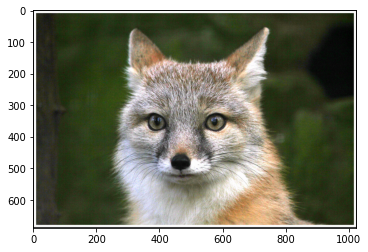

(689, 1024, 3)


In [48]:
img_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'

image_data = ImageData(img_url=img_url)

plt.imshow(image_data[0])  
plt.show()

print(image_data[0].shape) # (height, width, channel) = (689, 1024, 3)







## getting x, y coords of the image

image tensor before unsqueeze: torch.Size([3, 512, 512])
image tensor after unsqueeze: torch.Size([1, 3, 512, 512])
image tensor after squeeze: torch.Size([3, 512, 512])
image tensor after rearrange (height, width, channel): torch.Size([512, 512, 3])


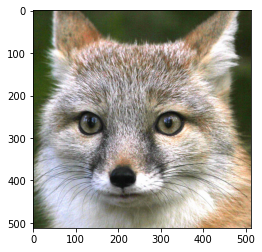

image tensor after unsqueeze: torch.Size([1, 512, 512, 3])
image tensor after rearrange (batch size, channel, height, weight): torch.Size([1, 3, 512, 512])
torch.Size([512, 512, 2])
torch.Size([1, 512, 512, 2])
torch.Size([1, 2, 512, 512])


In [49]:
transform = transforms.Compose([
    transforms.CenterCrop((512, 512)),
    transforms.ToTensor()
])

image_data.transform = transform

# print(image_data[0].size)
# print(len(image_data[0].mode))
# print(len(image_data))

image_tensor = image_data[0]

# image tensor (batch size, channel, height, width)
print(f'image tensor before unsqueeze: {image_tensor.shape}')

image_tensor = image_tensor.unsqueeze(0)

print(f'image tensor after unsqueeze: {image_tensor.shape}')

# show image (height, width, channel)
image_tensor = image_tensor.squeeze()

print(f'image tensor after squeeze: {image_tensor.shape}')

image_tensor = image_tensor.permute(1, 2, 0)

print(f'image tensor after rearrange (height, width, channel): {image_tensor.shape}')

plt.imshow(image_tensor)  
plt.show()

image_tensor = image_tensor.unsqueeze(0)

print(f'image tensor after unsqueeze: {image_tensor.shape}')

image_tensor = image_tensor.permute(0, 3, 1, 2)

print(f'image tensor after rearrange (batch size, channel, height, weight): {image_tensor.shape}')

xy_range = list(map(lambda x: x / 512, range(0, 512)))


xy_range_tensor = torch.tensor(xy_range, dtype=torch.float32)
x_grid, y_grid = torch.meshgrid(xy_range_tensor, xy_range_tensor)
xy_coord_tensor = torch.stack((x_grid, y_grid), dim=-1)

print(xy_coord_tensor.shape)

xy_coord_tensor = xy_coord_tensor.unsqueeze(0)

print(xy_coord_tensor.shape)

xy_coord_tensor = xy_coord_tensor.permute(0, 3, 1, 2)

print(xy_coord_tensor.shape)
# xy_coord = list(itertools.product(xy_range, xy_range))


# print(xy_coord)


# xy_coords_tensor = torch.tensor(xy_coord, dtype=torch.float32)

# print(f'xy coordinates tensor: {xy_coords_tensor.shape}')

# xy_coords_tensor = xy_coords_tensor.unsqueeze(0)
# # xy_coords_tensor = xy_coords_tensor.unsqueeze(0)

# print(f'xy coordinates tensor after add batch: {xy_coords_tensor.shape}')

# xy_coords_tensor = xy_coords_tensor.permute(0, 2, 1)

# print(f'xy coordinates tensor (batch, channel, coords): {xy_coords_tensor.shape}')


    







In [50]:
class GaussianFourier(nn.Module):

    def __init__(self, input_channel, output_channel):
        super().__init__()

        self.input_channel = input_channel 
        self.output_channel = output_channel
       
    def __len__(self):
    
        pass

    def __getitem__(self, idx):
     
        pass


    def forward(self, x):
        x = x * 2 * math.pi
        print(x.shape)
        

GaussianFourier(2, 512)(xy_coord_tensor)



torch.Size([1, 2, 512, 512])


In [55]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()

        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=512, out_channels=3, kernel_size=3, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers (224 * 224 -> 112 * 112 -> 56 * 56 -> 28 * 28)
        # self.fc1 = nn.Linear(256 * 64 * 64, n_hidden)
        # self.fc2 = nn.Linear(n_hidden, n_output)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        # x = self.pool(x)

        # x = self.flatten(x)
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc2(x)

        return x




In [56]:
model = CNN(n_output=3, n_hidden=1000)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01) 

# training model
for epoch in range(501):

    model.train()

    trained_image = model(xy_coord_tensor)

    loss = criterion(image_tensor, trained_image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(trained_image[0])
      plt.show()

RuntimeError: The size of tensor a (512) must match the size of tensor b (128) at non-singleton dimension 3